## Multi-Class Prediction of Obesity Risk 肥胖風險的多類別預測
- 利用各種因素來預測與心血管疾病相關的個人肥胖風險。
- 這些數據包括墨西哥、秘魯和哥倫比亞國家人口肥胖程度的估計，年齡在14 歲至61 歲之間，飲食習慣和身體狀況各不相同，數據是透過網路平台收集的，並進行了一項調查，其中匿名使用者回答了每個問題問題，然後對資訊進行處理，獲得 17 個屬性和 2111 條記錄。

#### 預測
- 肥胖類型 (target : NObeyesdad)

#### 特徵定義
- id &rArr; ID
- Gender &rArr; 性別
- Age &rArr; 年齡
- Height &rArr; 身高
- Weight &rArr; 體重
- family_history_with_overweight &rArr; 家族是否有肥胖史
- FAVC &rArr; 頻繁食用高熱量食物
- FCVC &rArr; 食用蔬菜頻率
- NCP &rArr; 主餐次數
- CAEC &rArr; 兩餐之間食物消耗量
- CH20 &rArr; 每日飲水量
- CALC &rArr; 酒精消耗量
- SCC &rArr; 卡路里消耗監測
- FAF &rArr; 體力活動頻率
- TUE &rArr; 使用科技設備的時間
- MTRANS &rArr; 使用的交通工具
- NObesity 值為 BMI 類別：
    - Insufficient_Weight : BMI 小於18.5
    - Normal_Weight : BMI18.5至24.9
    - Overweight : BMI25.0至29.9
    - Obesity I : BMI 30.0至34.9
    - Obesity II : BMI 35.0至39.9
    - Obesity III : BMI 高於40


In [23]:
import pandas as pd
import numpy as np

import seaborn as sns
color = sns.color_palette() # 生成各種顏色
sns.set_style('darkgrid') # 設置主題：darkgrid、whitegrid、dark、white、ticks
import matplotlib.pyplot as plt
%matplotlib inline

from pandas_summary import DataFrameSummary

import warnings 
warnings.filterwarnings('ignore')

import lightgbm as lgb
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder

#### 載入資料集

In [24]:
df_train = pd.read_csv('./data/Multi-Class Prediction of Obesity Risk/train.csv')
df_test = pd.read_csv('./data/Multi-Class Prediction of Obesity Risk/test.csv')

df_train.head(5)

,id,Gender,Age,Height,Weight,family_history_with_overweight,FAVC,FCVC,NCP,CAEC,SMOKE,CH2O,SCC,FAF,TUE,CALC,MTRANS,NObeyesdad
0,0,Male,24.443011,1.699998,81.669950,yes,yes,2.000000,2.983297,Sometimes,no,2.763573,no,0.000000,0.976473,Sometimes,Public_Transportation,Overweight_Level_II
1,1,Female,18.000000,1.560000,57.000000,yes,yes,2.000000,3.000000,Frequently,no,2.000000,no,1.000000,1.000000,no,Automobile,Normal_Weight
2,2,Female,18.000000,1.711460,50.165754,yes,yes,1.880534,1.411685,Sometimes,no,1.910378,no,0.866045,1.673584,no,Public_Transportation,Insufficient_Weight
3,3,Female,20.952737,1.710730,131.274851,yes,yes,3.000000,3.000000,Sometimes,no,1.674061,no,1.467863,0.780199,Sometimes,Public_Transportation,Obesity_Type_III
4,4,Male,31.641081,1.914186,93.798055,yes,yes,2.679664,1.971472,Sometimes,no,1.979848,no,1.967973,0.931721,Sometimes,Public_Transportation,Overweight_Level_II


#### 建構新特徵

In [25]:
df_train.drop("id", axis = 1, inplace = True)
df_test.drop("id", axis = 1, inplace = True)

df_train['BMI'] = df_train['Weight'] / (df_train['Height']) ** 2
df_test['BMI'] = df_test['Weight'] / (df_test['Height']) ** 2

#### 調整目標 肥胖標籤順序

In [26]:
df_train.describe().style.background_gradient()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,BMI
count,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000,20758.000000
mean,23.841804,1.700245,87.887768,2.445908,2.761332,2.029418,0.981747,0.616756,30.241842
std,5.688072,0.087312,26.379443,0.533218,0.705375,0.608467,0.838302,0.602113,8.333932
min,14.000000,1.450000,39.000000,1.000000,1.000000,1.000000,0.000000,0.000000,12.868541
25%,20.000000,1.631856,66.000000,2.000000,3.000000,1.792022,0.008013,0.000000,24.088223
50%,22.815416,1.700000,84.064875,2.393837,3.000000,2.000000,1.000000,0.573887,29.384757
75%,26.000000,1.762887,111.600553,3.000000,3.000000,2.549617,1.587406,1.000000,37.011168
max,61.000000,1.975663,165.057269,3.000000,4.000000,3.000000,3.000000,2.000000,54.997991


In [27]:
# 創建摘要
feature_numerical = [feature for feature in df_train.columns if df_train[feature].dtypes != 'O']
df_summary = DataFrameSummary(df_train[feature_numerical])

# 顯示摘要統計信息
df_summary.summary()

,Age,Height,Weight,FCVC,NCP,CH2O,FAF,TUE,BMI
count,20758.0,20758.0,20758.0,20758.0,20758.0,20758.0,20758.0,20758.0,20758.0
mean,23.841804,1.700245,87.887768,2.445908,2.761332,2.029418,0.981747,0.616756,30.241842
std,5.688072,0.087312,26.379443,0.533218,0.705375,0.608467,0.838302,0.602113,8.333932
min,14.0,1.45,39.0,1.0,1.0,1.0,0.0,0.0,12.868541
25%,20.0,1.631856,66.0,2.0,3.0,1.792022,0.008013,0.0,24.088223
50%,22.815416,1.7,84.064875,2.393837,3.0,2.0,1.0,0.573887,29.384757
75%,26.0,1.762887,111.600553,3.0,3.0,2.549617,1.587406,1.0,37.011168
max,61.0,1.975663,165.057269,3.0,4.0,3.0,3.0,2.0,54.997991
counts,20758,20758,20758,20758,20758,20758,20758,20758,20758
uniques,1703,1833,1979,934,689,1506,1360,1297,12605


In [28]:
# 指定NObeyesdad的順序
custom_order = ['Insufficient_Weight', 'Normal_Weight', 'Overweight_Level_I', 'Overweight_Level_II', 'Obesity_Type_I', 'Obesity_Type_II', 'Obesity_Type_III']

# 將NObeyesdad轉換為類別型數據類型，並指定順序
df_train['NObeyesdad'] = pd.Categorical(df_train['NObeyesdad'], categories=custom_order, ordered=True)

In [29]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20758 entries, 0 to 20757
Data columns (total 18 columns):
 #   Column                          Non-Null Count  Dtype   
---  ------                          --------------  -----   
 0   Gender                          20758 non-null  object  
 1   Age                             20758 non-null  float64 
 2   Height                          20758 non-null  float64 
 3   Weight                          20758 non-null  float64 
 4   family_history_with_overweight  20758 non-null  object  
 5   FAVC                            20758 non-null  object  
 6   FCVC                            20758 non-null  float64 
 7   NCP                             20758 non-null  float64 
 8   CAEC                            20758 non-null  object  
 9   SMOKE                           20758 non-null  object  
 10  CH2O                            20758 non-null  float64 
 11  SCC                             20758 non-null  object  
 12  FAF               

#### EDA

##### 數值特徵
> - 肥胖程度與體重、BMI呈現正相關
> - 肥胖程度越高飲水次數似乎越高 ?
> - 肥胖 III 型的人, 高頻率吃菜

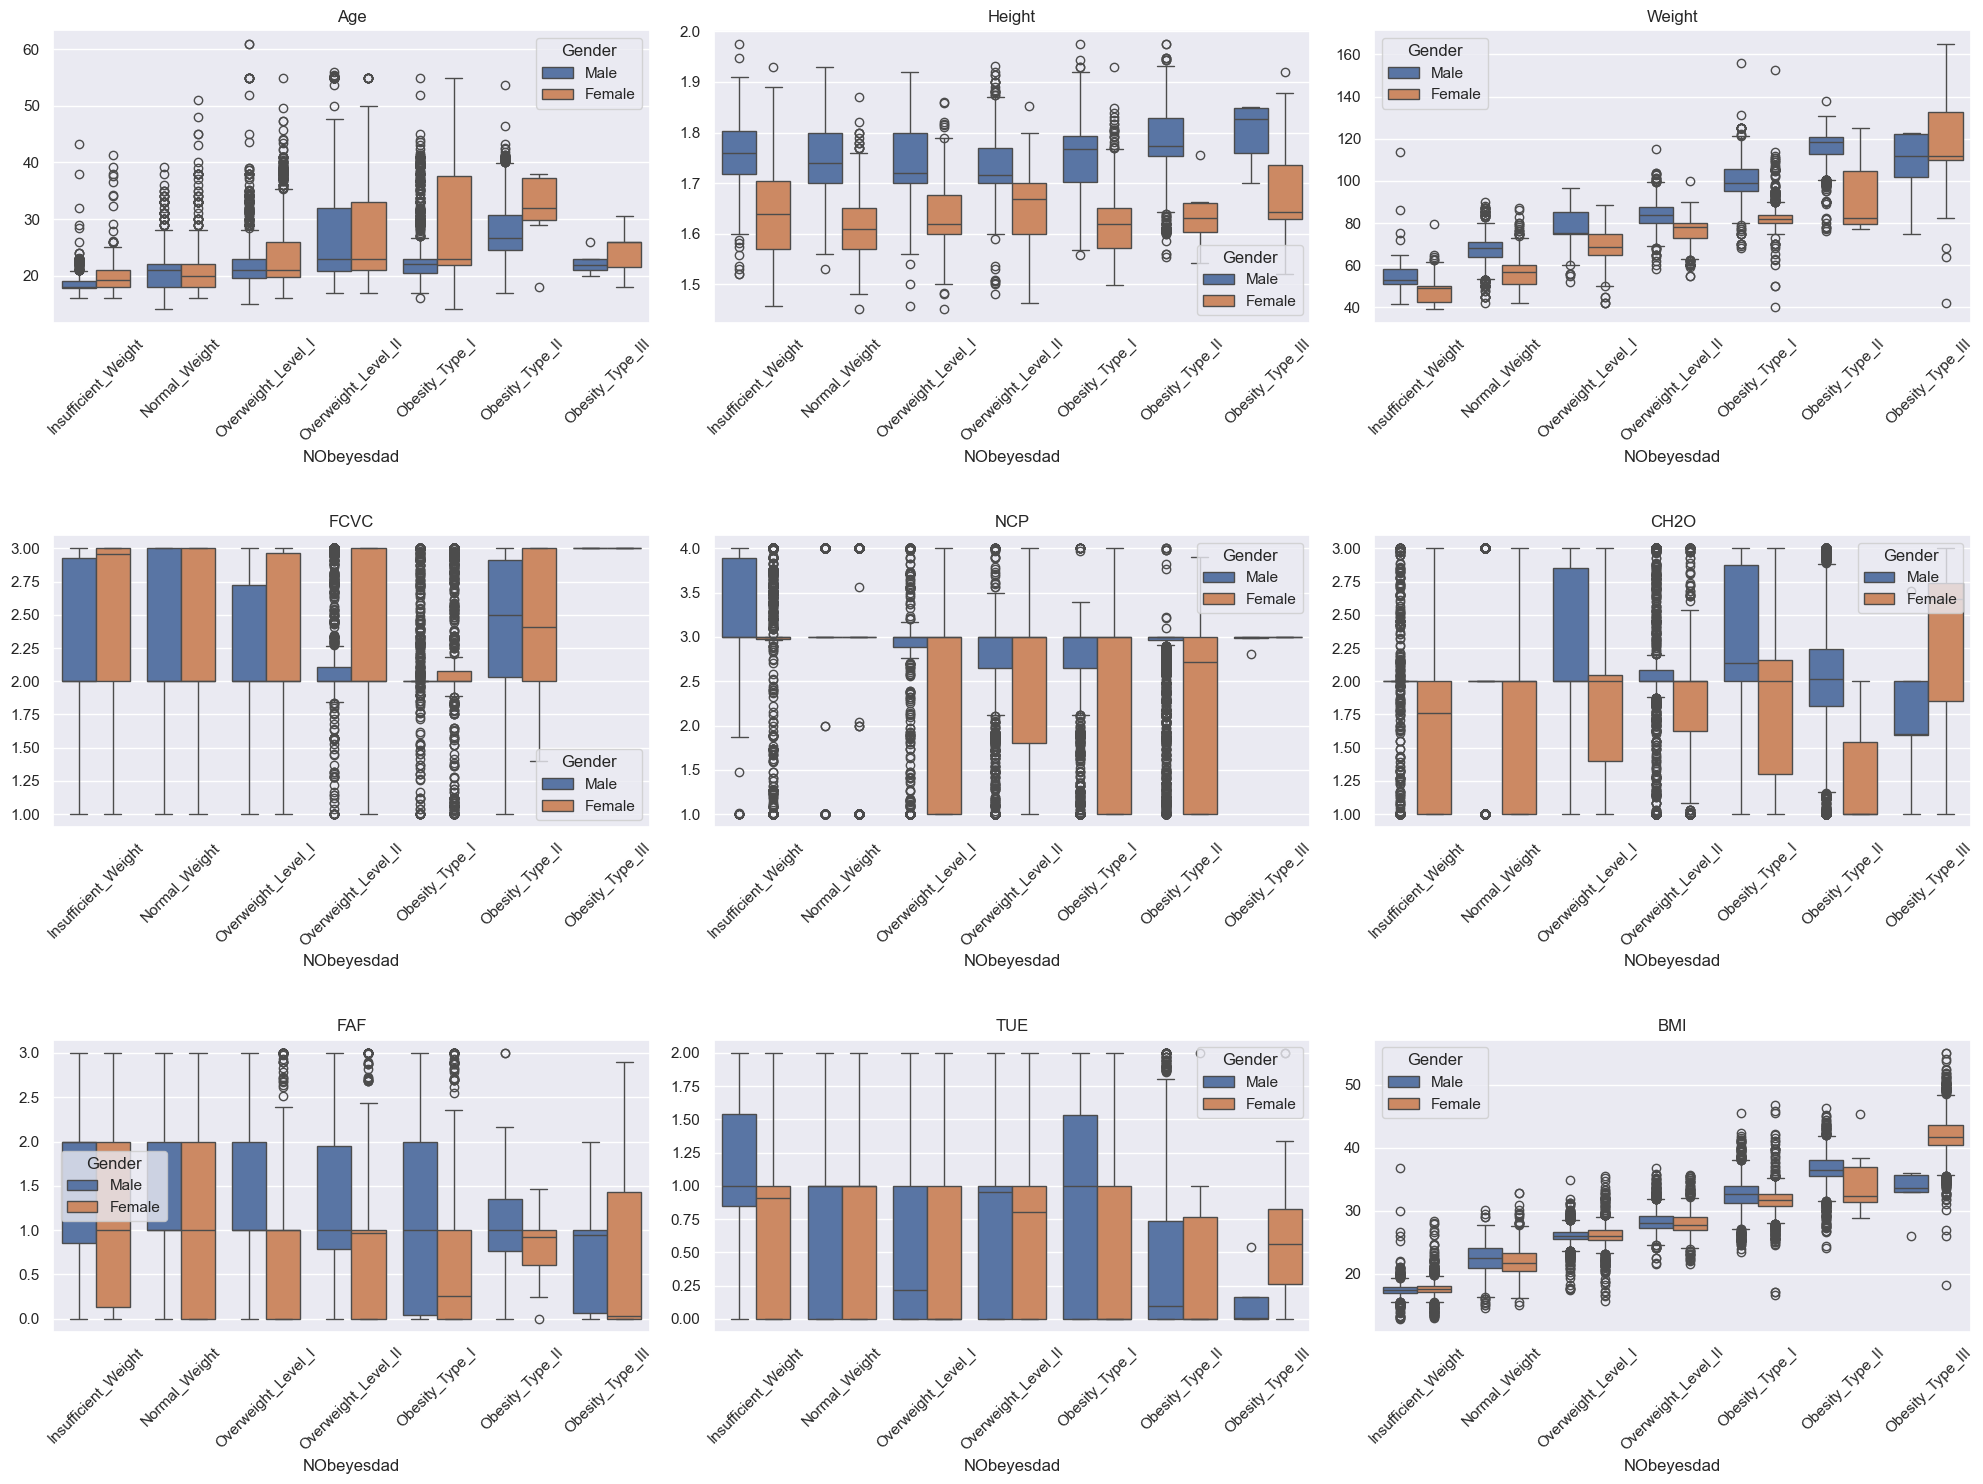

In [30]:
feature_numerical = [feature for feature in df_train.columns if df_train[feature].dtypes != 'O']

fig, axes = plt.subplots(3, 3)
sns.set(rc={'figure.figsize':(20, 15)})

row, col = 0, 0
for i, source in enumerate(feature_numerical):
    if source == "NObeyesdad":
        continue
    sns.boxplot(x = "NObeyesdad", hue="Gender", y = source, data = df_train, ax = axes[row, col], palette='deep')
        
    # 將設置移動到每個子圖的設置區域內
    axes[row, col].set_xticklabels(axes[row, col].get_xticklabels(), rotation=45)
    axes[row, col].set_title(source, y=1)
    axes[row, col].set_ylabel('')
    plt.tight_layout(h_pad=3)
    
    col += 1
    if col > 2:
        row += 1
        col = 0
plt.show()


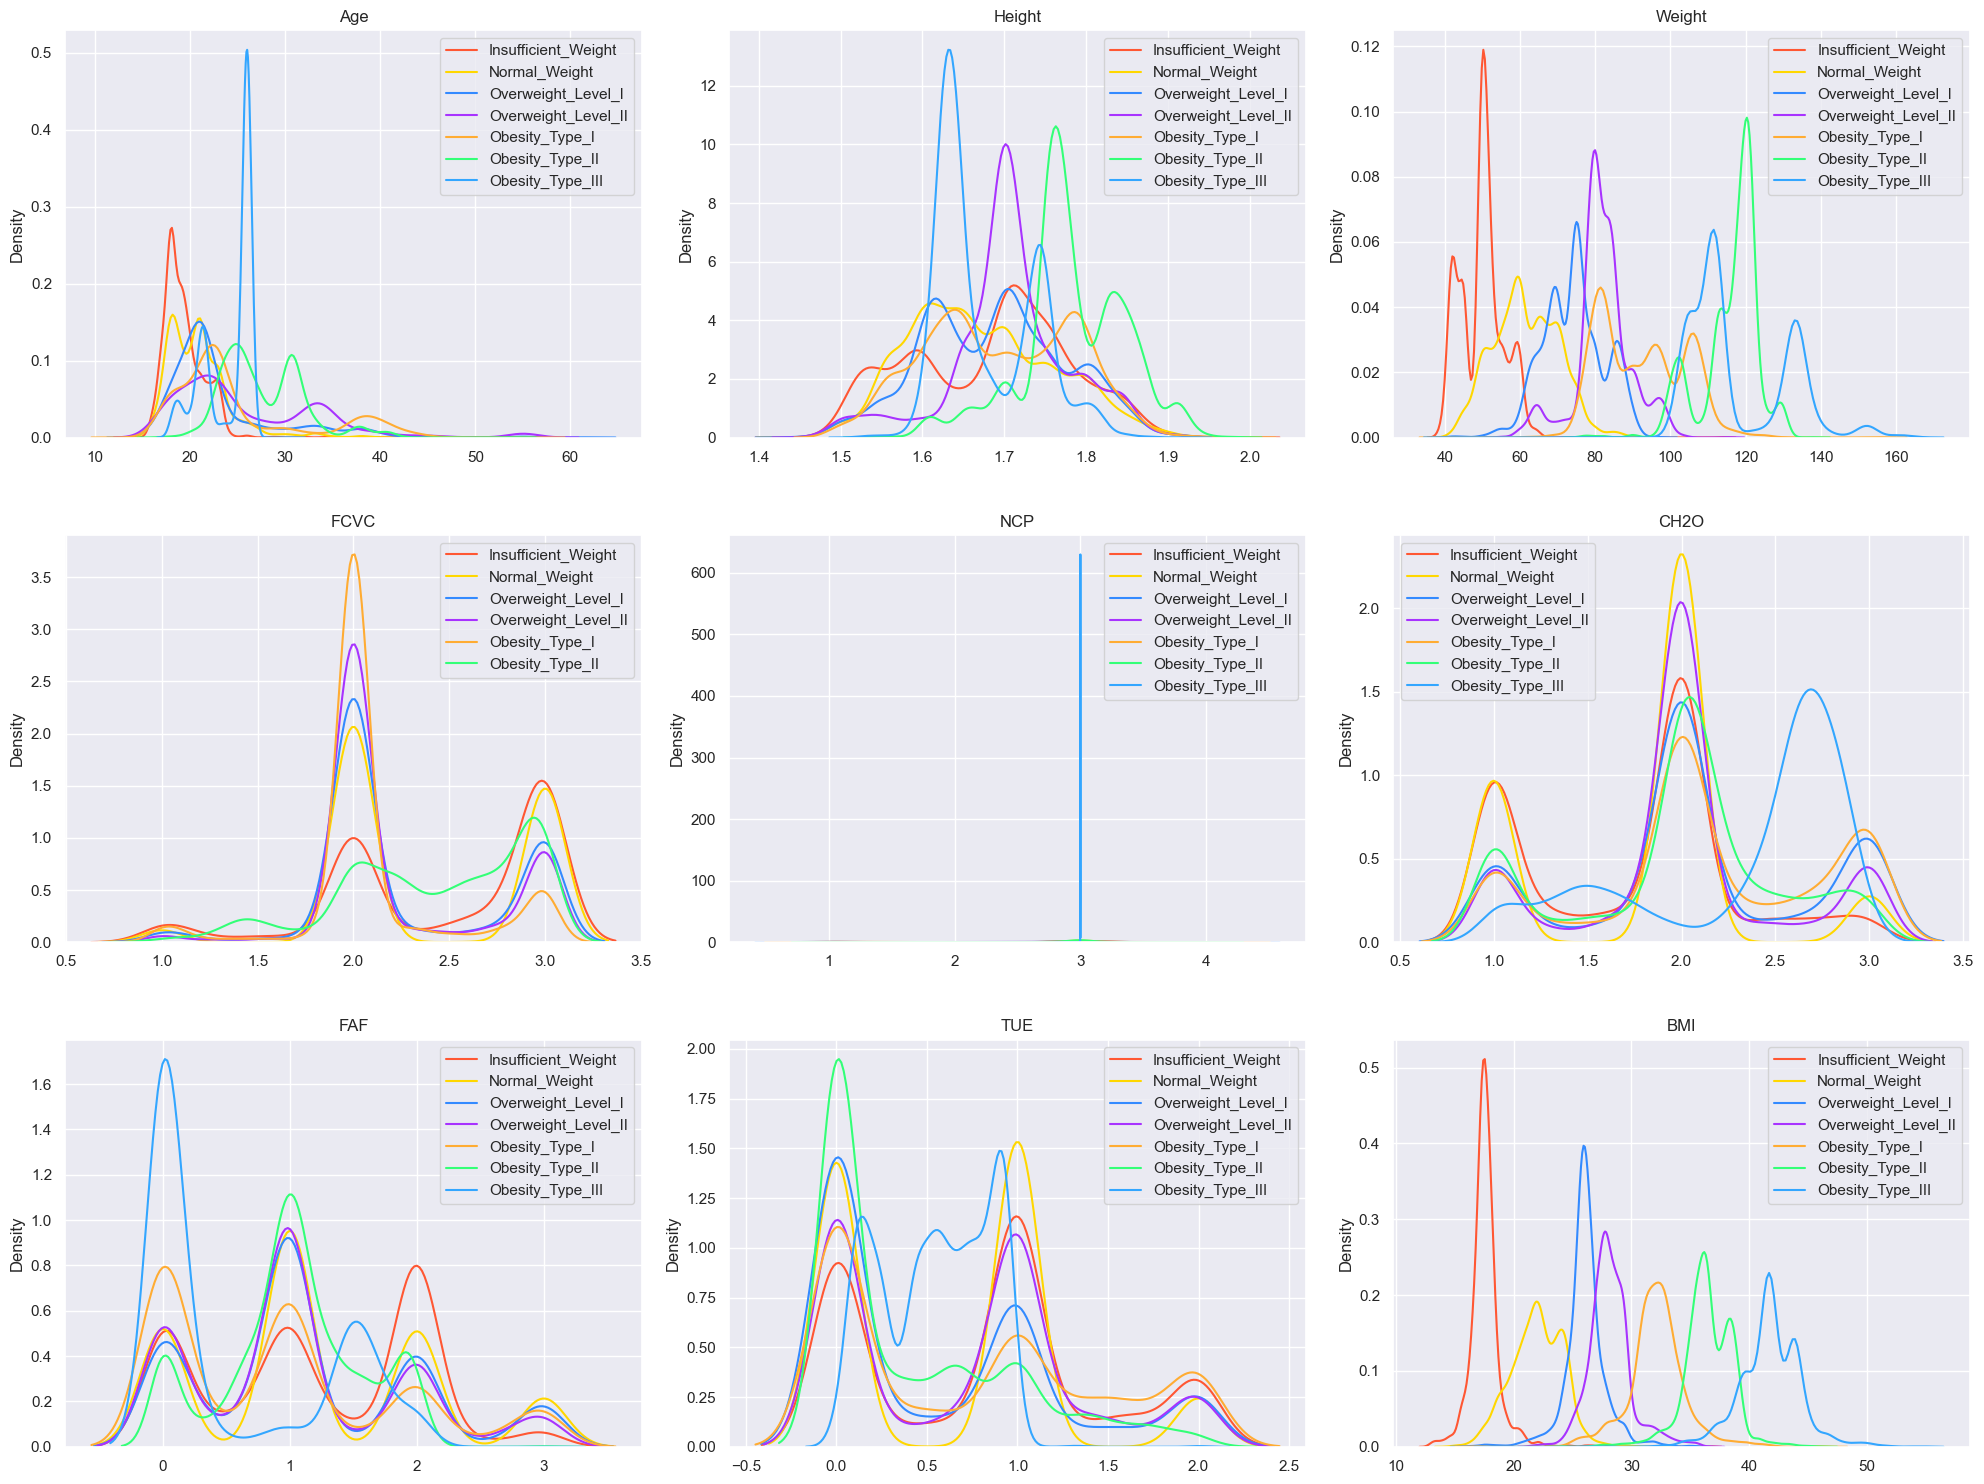

In [31]:
# feature_numerical 取得數值型特徵
feature_numerical = [feature for feature in df_train.columns if df_train[feature].dtypes != 'O']

colors = ["#FF5733", "#FFD700", "#FFAC33", "#33FF77", "#33A6FF", "#338AFF", "#A833FF"]

# 觀察數值類型的特徵
count = 0
plt.figure(figsize=(20,15))
for i, source in enumerate(feature_numerical):
    
    if source == "NObeyesdad":
        continue
    
    # 指定好子圖的位置 
    count += 1
    plt.subplot(3, 3, count)

    # 增加核密度估計
    sns.kdeplot(df_train.loc[df_train['NObeyesdad']=='Insufficient_Weight', source], color = colors[0], label='Insufficient_Weight')
    sns.kdeplot(df_train.loc[df_train['NObeyesdad']=='Normal_Weight', source], color = colors[1], label='Normal_Weight')
    sns.kdeplot(df_train.loc[df_train['NObeyesdad']=='Overweight_Level_I', source], color = colors[5], label='Overweight_Level_I')
    sns.kdeplot(df_train.loc[df_train['NObeyesdad']=='Overweight_Level_II', source], color = colors[6], label='Overweight_Level_II')
    sns.kdeplot(df_train.loc[df_train['NObeyesdad']=='Obesity_Type_I', source], color = colors[2], label='Obesity_Type_I')
    sns.kdeplot(df_train.loc[df_train['NObeyesdad']=='Obesity_Type_II', source], color = colors[3], label='Obesity_Type_II')
    sns.kdeplot(df_train.loc[df_train['NObeyesdad']=='Obesity_Type_III', source], color = colors[4], label='Obesity_Type_III')
    plt.legend()    
    plt.title(source, y=1)
    
    # 隱藏下方的標題
    plt.xlabel('')
    # plt.ylabel('')
    
    # 增加子圖間的間隙
    plt.tight_layout(h_pad=3)
plt.show()

##### 類別特徵
> - Obesity_Type_II 中的所有人員均為男性，Obesity_Type_III 中的所有人員均為女性

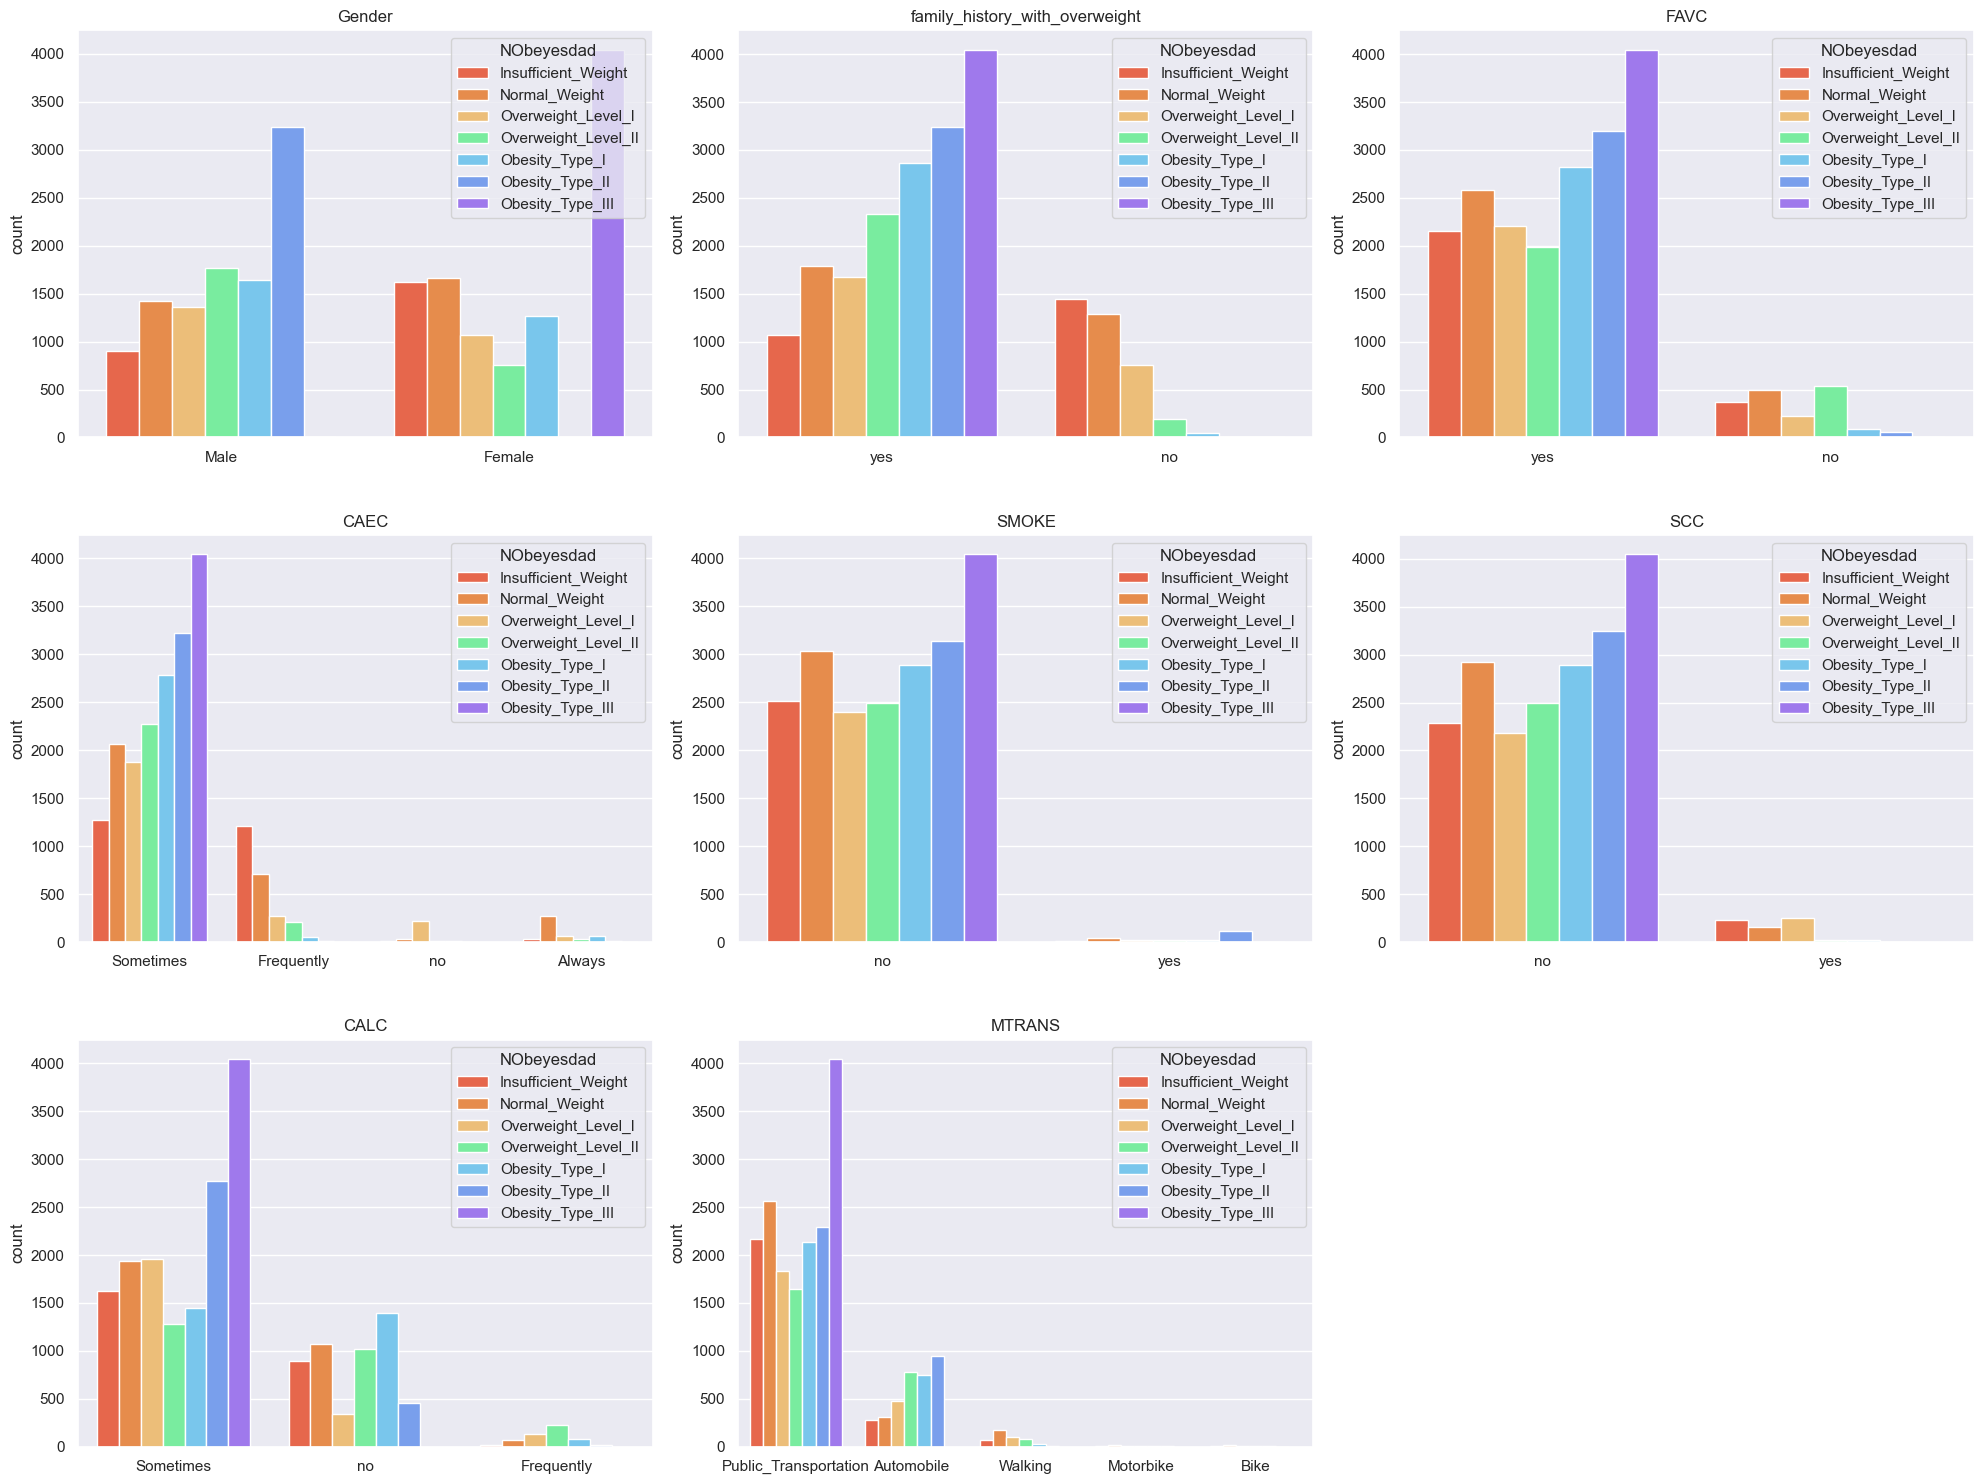

In [32]:
feature_object = [feature for feature in df_train.columns if df_train[feature].dtypes == 'O']

colors = ["#FF5733", "#FF8833", "#FFC266", "#66FF99", "#66CCFF", "#6699FF", "#9966FF"]

# 觀察 Object 類型的特徵
plt.figure(figsize = (20, 15))
for i, source in enumerate(feature_object):
    # 指定好子圖的位置 
    plt.subplot(3, 3, i+1)
    sns.countplot(data = df_train, x = source, hue = 'NObeyesdad', palette = colors).set(xlabel=None)
    plt.title(source)
    if source == 'NObeyesdad':
        plt.xticks(rotation=45)
    # 增加子圖間的間隙
    plt.tight_layout(h_pad=3)
plt.show()

##### 特別觀察
- BMI 的關係
  > - 可以看出 bmi 分布

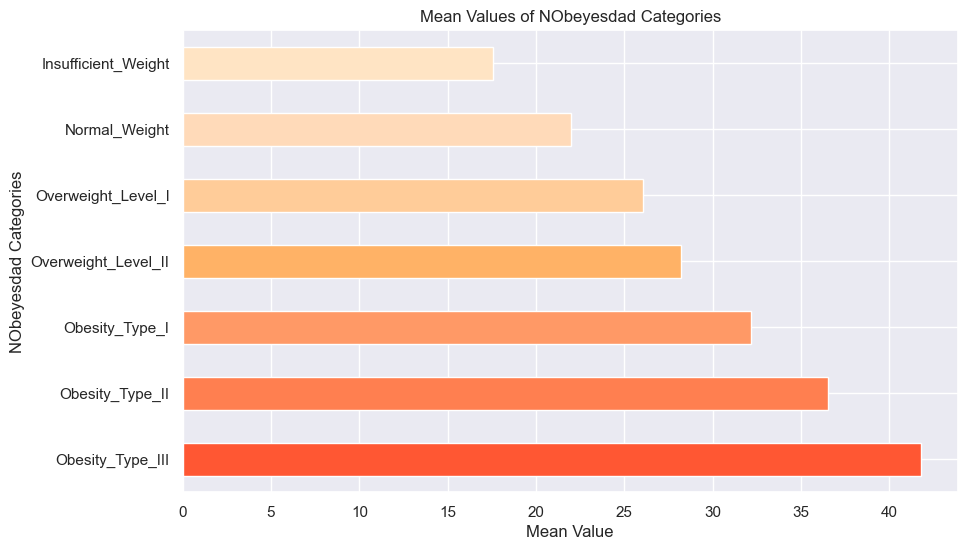

In [33]:
# 計算每個類別的平均值
mean_values = df_train.groupby("NObeyesdad")['BMI'].mean()

# 按照平均值大小進行排序
mean_values_sorted = mean_values.sort_values(ascending=False)

colors = ["#FF5733", "#FF7F50", "#FF9966", "#FFB266", "#FFCC99", "#FFDAB9", "#FFE4C4"]

# 繪製平均值成圖
mean_values_sorted.plot(kind="barh", figsize=(10, 6), color=colors)
plt.title("Mean Values of NObeyesdad Categories")
plt.xlabel("Mean Value")
plt.ylabel("NObeyesdad Categories")
plt.show()

- 交通工具
  > - 可以看出過重的人, 基本上不選擇自己走路
  > - bmi 越高的人, 使用大眾運輸工具的比例就越高

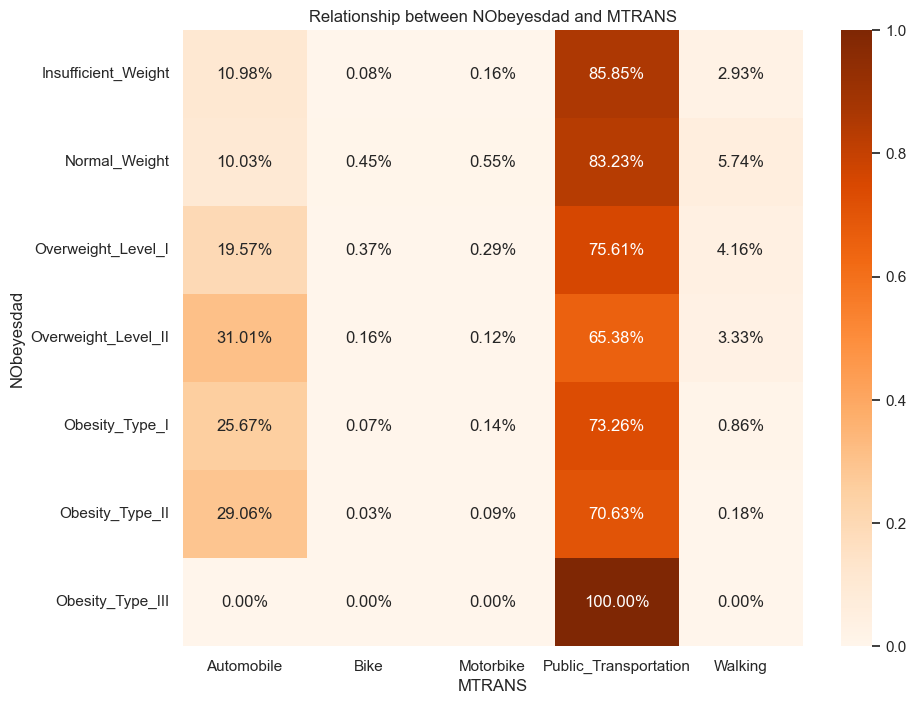

In [34]:
# 使用交叉表計算計數
cross_tab = pd.crosstab(df_train["NObeyesdad"], df_train["MTRANS"], normalize='index')  # normalize='index' 將每行的值轉換為百分比

# 定義暖色系色板
warm_palette = sns.color_palette("Oranges", as_cmap=True)

# 繪製熱圖
plt.figure(figsize=(10, 8))
sns.heatmap(cross_tab, annot=True, cmap=warm_palette, fmt='.2%')  # 使用暖色系色板
plt.title("Relationship between NObeyesdad and MTRANS")
plt.xlabel("MTRANS")
plt.ylabel("NObeyesdad")
plt.show()

- 活動次數
> - 越胖的人 越懶得走路
> - 女性的活動力 小於男性

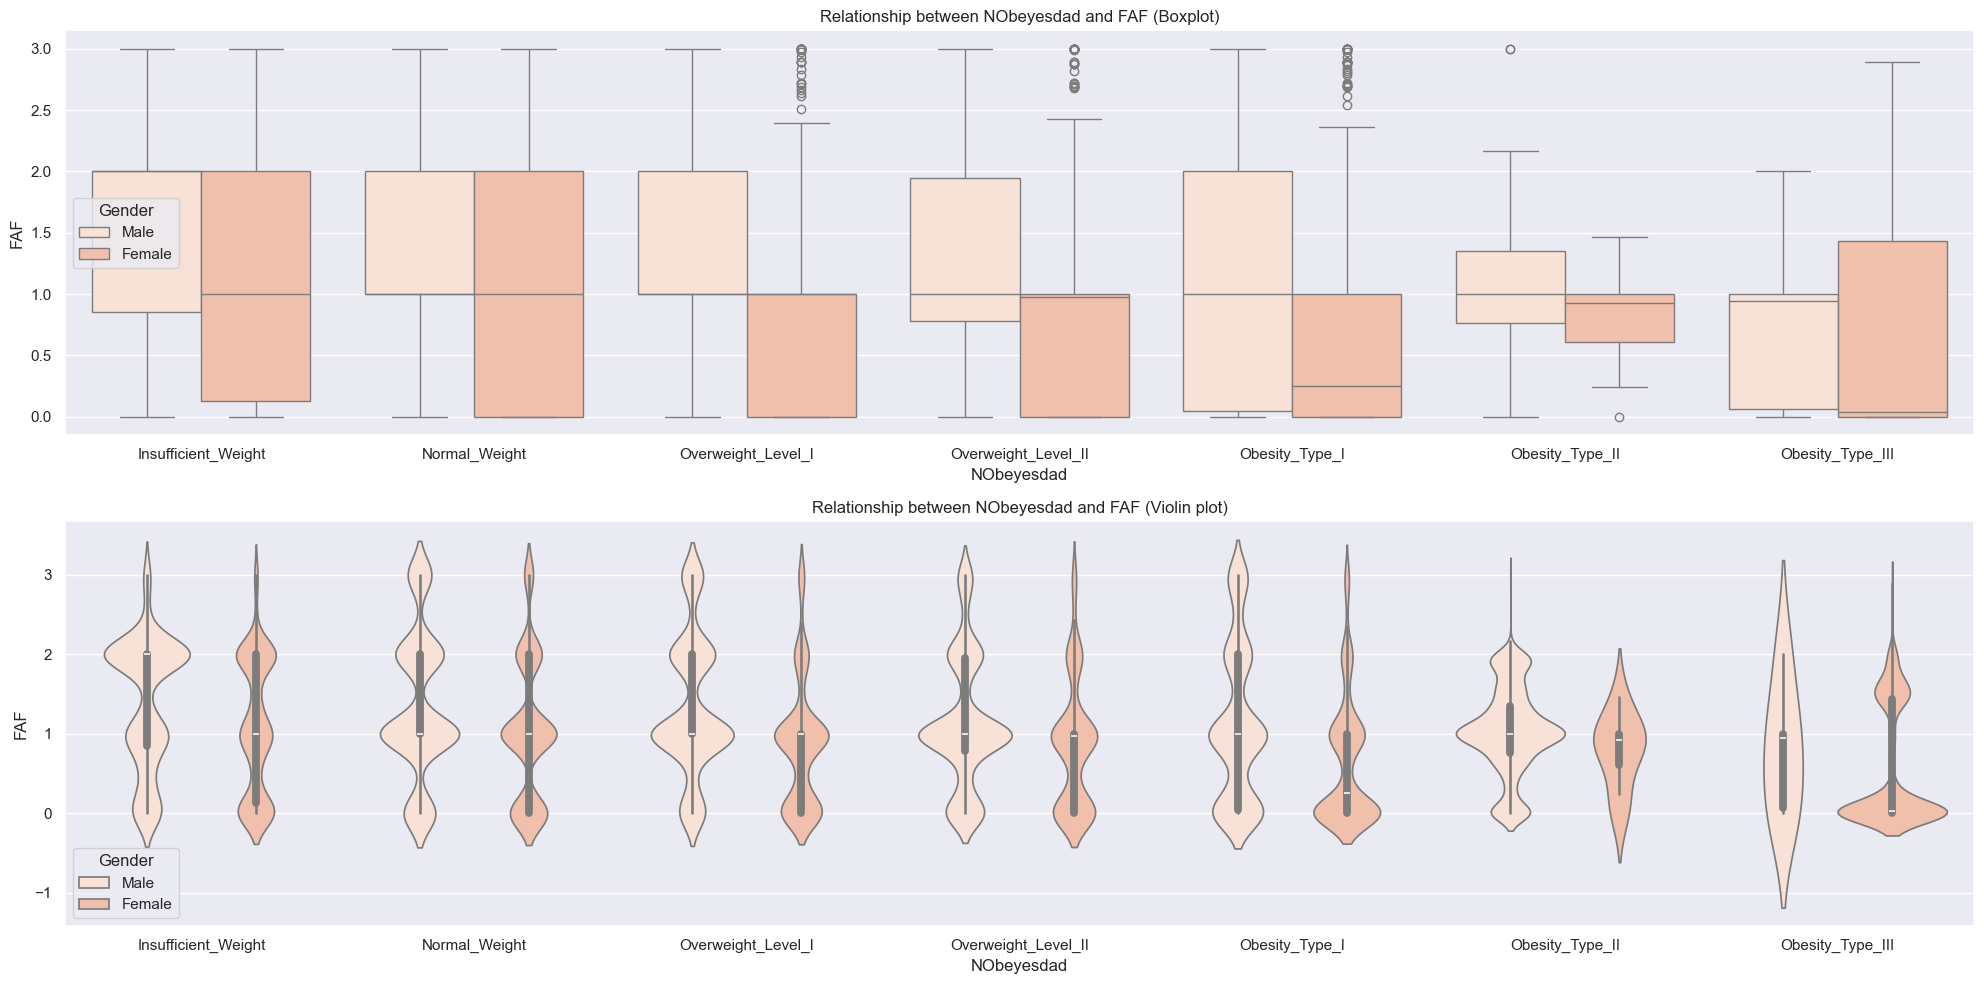

In [35]:
# 使用暖色系色板
warm_palette = sns.color_palette("Reds", len(custom_order))

# 創建一個包含兩個子圖的Figure
fig, axes = plt.subplots(2, 1, figsize=(20, 10))

# 箱形圖
sns.boxplot(x='NObeyesdad', y='FAF', hue="Gender", data=df_train, palette=warm_palette, ax=axes[0])
axes[0].set_title('Relationship between NObeyesdad and FAF (Boxplot)')
axes[0].set_xlabel('NObeyesdad')
axes[0].set_ylabel('FAF')

# 小提琴圖
sns.violinplot(x='NObeyesdad', y='FAF', hue="Gender", data=df_train, palette=warm_palette, ax=axes[1])
axes[1].set_title('Relationship between NObeyesdad and FAF (Violin plot)')
axes[1].set_xlabel('NObeyesdad')
axes[1].set_ylabel('FAF')

# 調整子圖之間的間距
plt.tight_layout()

# 顯示圖表
plt.show()

#### 資料前處理

In [36]:
original = pd.read_csv('./data/Multi-Class Prediction of Obesity Risk/ObesityDataSet.csv')
train = pd.concat([df_train, original]).drop_duplicates()
test = df_test

train = pd.get_dummies(train, columns=feature_object, drop_first=True)
test = pd.get_dummies(test, columns=feature_object, drop_first=True)

print(f'The encoded Train dataset has {train.shape[0]} rows and {train.shape[1]} columns')
print(f'The encoded Test dataset has {test.shape[0]} rows and {test.shape[1]} columns')

X = train.drop(['NObeyesdad'], axis=1)
y = train['NObeyesdad']

print(f'X.shape : {X.shape}')
print(f'Y.shape : {y.shape}')

# Splitting the dataset into the Training set and Test set
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

The encoded Train dataset has 22845 rows and 25 columns
The encoded Test dataset has 13840 rows and 24 columns
X.shape : (22845, 24)
Y.shape : (22845,)


#### 建立模型
> - LGBMClassifier

In [37]:
best_params = {
    "objective": "multiclass",          # Objective function for the model
    "metric": "multi_logloss",          # Evaluation metric
    "verbosity": -1,                    # Verbosity level (-1 for silent)
    "boosting_type": "gbdt",            # Gradient boosting type
    "random_state": 42,       # Random state for reproducibility
    "num_class": 7,                     # Number of classes in the dataset
    'learning_rate': 0.030962211546832760,  # Learning rate for gradient boosting
    'n_estimators': 500,                # Number of boosting iterations
    'lambda_l1': 0.009667446568254372,  # L1 regularization term
    'lambda_l2': 0.04018641437301800,   # L2 regularization term
    'max_depth': 10,                    # Maximum depth of the trees
    'colsample_bytree': 0.40977129346872643,  # Fraction of features to consider for each tree
    'subsample': 0.9535797422450176,    # Fraction of samples to consider for each boosting iteration
    'min_child_samples': 26             # Minimum number of data needed in a leaf
}

lgbm_classifier = lgb.LGBMClassifier(**best_params)
lgbm_classifier.fit(X_train, y_train)
y_pred = lgbm_classifier.predict(X_test)

accuracy_score(y_test, y_pred) 

0.9142044210987087

In [38]:
predictions = lgbm_classifier.predict(test)

In [ ]:
# original = pd.read_csv('./data/Multi-Class Prediction of Obesity Risk/ObesityDataSet.csv')

# df_train_encode = df_train.copy()
# columns_to_encode = feature_object
# df_encoded = pd.get_dummies(data = df_train, columns = columns_to_encode, drop_first=True)
# new_columns = df_encoded.columns.difference(df_train.columns)
# df_train_encode[new_columns] = df_encoded[new_columns].astype(int)

# df_train_encode.drop(feature_object, axis = 1, inplace = True)
# df_train_encode

In [ ]:
# df_test_encode = df_test.copy()
# columns_to_encode = feature_object
# df_encoded = pd.get_dummies(data = df_test, columns = columns_to_encode, drop_first=True)
# new_columns = df_encoded.columns.difference(df_test.columns)
# df_test_encode[new_columns] = df_encoded[new_columns].astype(int)

# df_test_encode.drop(feature_object, axis = 1, inplace = True)
# df_test_encode

In [ ]:
# # 檢查 df_train 與 test_data 的列是否相同
# train_columns = set(df_train_encode.columns)
# test_columns = set(df_test_encode.columns)

# # 確保 df_train 與 test_data 具有相同的列
# missing_columns_in_train = test_columns - train_columns
# missing_columns_in_test = train_columns - test_columns

# # 在 df_train 與 test_data 中新增缺失的列，並將其值設為 0
# for column in missing_columns_in_train:
#     df_train_encode[column] = 0

# for column in missing_columns_in_test:
#     if column == "NObeyesdad":
#         continue
#     df_test_encode[column] = 0


#### 準備訓練資料

In [ ]:
# # 訓練資料處理
# X_train = df_train_encode.drop(['NObeyesdad'], axis = 1) 
# y_train = df_train_encode['NObeyesdad']
# X_test = df_test_encode

# print(f'df_train shape: {df_train.shape}')
# print(f'X_train shape: {X_train.shape}')
# print(f'y_train shape: {y_train.shape}')
# print(f'X_test shape: {X_test.shape}')

# label_encoder = LabelEncoder()
# y_train_encoded = label_encoder.fit_transform(y_train)
# X_train_split, X_val_split, y_train_split, y_val_split = train_test_split(X_train, y_train_encoded, test_size=0.2, random_state=42)

##### LGBM

In [ ]:
# params = {
#     'objective': 'multiclass',
#     'num_class': len(label_encoder.classes_),  # 根據類別的數量設置
#     'metric': 'multi_logloss',
#     'early_stopping_round': 10  # 將 early_stopping_round 移到 params 字典中
# }

# train_data = lgb.Dataset(X_train_split, label=y_train_split)
# val_data = lgb.Dataset(X_val_split, label=y_val_split)
# num_round = 100
# bst = lgb.train(params, train_data, num_round, valid_sets=[val_data])
# y_pred = bst.predict(X_test, num_iteration=bst.best_iteration)

#### 輸出結果

In [ ]:
# y_pred_decoded = label_encoder.inverse_transform(np.argmax(y_pred, axis=1))
# y_pred_decoded

In [ ]:
sub = pd.read_csv('./data/Multi-Class Prediction of Obesity Risk/sample_submission.csv')
submission = pd.DataFrame()
submission['id'] = sub['id']
submission['NObeyesdad'] = predictions
submission.to_csv('./data/Multi-Class Prediction of Obesity Risk/submission_lgb_pred.csv', index = False)